# Instituto de Educação Superior de Brası́lia – IESB
## Pós-Graduação em Inteligência Artificial
### Disciplina de Computação Cognitiva 3 / Turma 2021-1
#### Trabalho Final - Análise de Sentimento

                          EQUIPE:
                          - LUCAS DE SOUSA BRITO, MAT:2186330019, TURMA: 2021-1
                          - PABLO NOGUEIRA OLIVEIRA, MAT:2186330027, TURMA: 2021-1
                          - MATHEUS BARBOSA OLIVEIRA, MAT:2186330037, TURMA: 2021-1

# Análise de sentimento da base do twitter Sentiment140

### Dados de Origem

* http://help.sentiment140.com/for-students

| sentiment  | id | date | query_string | user | text
| ---        | -- | -    | -            | -    | ---
| 0=negativo | -  | -    | -            | -    | the original twitter message
| 2=neutro   | -  | -    | -            | -    | 
| 4=positivo | -  | -    | -            | -    |


```



In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np

tf.random.set_seed(129783)
np.random.seed(3213)

# Importação

Dados de origem: 
* http://help.sentiment140.com/for-students
* colunas:
   * sentiment (0=negativo, 2=neutro, 4=positivo)
   * id
   * date
   * query_string
   * user
   * text

Para este exercício:
* apenas as colunas sentiment e text serão mantidas
* sentimentos neutros serão descartados
* sentimentos serão padronizados como 0=negativo e 1=positivo


In [3]:
def bloco():
    
    global df_original
    
    df_cols = ['sentiment','id','date','query_string','user','text']

    df_original = pd.read_csv(
        "training.1600000.processed.noemoticon.csv",
        header=None, 
        names=df_cols,
        encoding = "ISO-8859-1"
    )

    df_original.drop(
        ['id','date','query_string','user'],
        axis=1,
        inplace=True
    )
    df_original = df_original[ df_original['sentiment'] != 2 ] 
    df_original['sentiment'] = df_original['sentiment'].apply( lambda x: 1 if x==0 else 0 )
    return df_original

bloco()

,sentiment,text
0,1,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,1,is upset that he can't update his Facebook by ...
2,1,@Kenichan I dived many times for the ball. Man...
3,1,my whole body feels itchy and like its on fire
4,1,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,0,Just woke up. Having no school is the best fee...
1599996,0,TheWDB.com - Very cool to hear old Walt interv...
1599997,0,Are you ready for your MoJo Makeover? Ask me f...
1599998,0,Happy 38th Birthday to my boo of alll time!!! ...


# Padronização (1)

* Parte 1
  * remove todas as tags
  * remove urls
  * remove identificadores de usuários 
  * remove caracteres unicode inválidos
  * remove carcteres não textuais
  * transforma tudo para minúsculas
* Parte 2
  * tokeniza usando o keras
* Parte 3
  * separa base de treinamento e de teste

In [4]:
#data_limit = 200000
max_words = 100000
max_len = 1000

def bloco():
    
    global df_original
    global df_train
    global df_test   
   
    # PARTE 1 - Limpa o texto 
    import re
    pat1 = r'@[A-Za-z0-9]+'
    pat2 = r'https?://[A-Za-z0-9./]+'
    pat3 = r'<.*?>'
    pat4 = r'&.*?;'
    pat = r'|'.join((pat1, pat2, pat3, pat4))
    def tweet_cleaner(text):       
        text = re.sub(pat,'',text)
        try:
            text = text.decode("utf-8-sig").replace(u"\ufffd", "?")
        except:
            text = text
        text = re.sub("[^a-zA-Z]", " ", text)
        text = text.lower()
        return text

    df_original['text2'] = df_original['text'].apply( tweet_cleaner )

    
    # PARTE 2 - Tokeniza usando o Keras
    global tokenizer
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_words,lower=True, split=" ")
    tokenizer.fit_on_texts(df_original['text2'])
    #df_original['text3'] = tokenizer.texts_to_sequences(df_original['text2'])
    #df_original['text4'] = tf.keras.preprocessing.sequence.pad_sequences(
    #    df_original['text3'], 
    #    maxlen=max_len,
    #    #padding='post',
    #    #truncating='post'        
    #).tolist()                                                                                                   
   

    global df_example
    df_example = df_original.sample(15)
    df_example['text3'] = tokenizer.texts_to_sequences(df_example['text2'])
    df_example['text4'] = tf.keras.preprocessing.sequence.pad_sequences( df_example['text3'], maxlen=max_len ).tolist()              
        
    # PARTE 3 - Separa amostra de treinamento e de teste
   
    # 1 = train | 0 = test
    df_original['rand'] = pd.Series([0,1]).sample(len(df_original), replace=True).array
    
    df_train_sz = 10000
    df_train = df_original[ df_original[ 'rand' ] == 1 ]
    df_train_positive = df_train[ df_train['sentiment'] == 0 ].sample(n=int(df_train_sz/2), replace=True)
    df_train_negative = df_train[ df_train['sentiment'] == 1 ].sample(n=int(df_train_sz/2), replace=True)
    df_train = pd.concat( [ df_train_negative, df_train_positive ] )    
    df_train = df_train.sample(frac=1.0).reset_index(drop=True)
    
    df_test_sz = 40000
    df_test = df_original[ df_original[ 'rand' ] == 0 ].sample(int(df_test_sz/2), replace=True)
    df_test = df_test.sample(frac=1.0).reset_index(drop=True)
    
    
bloco()
df_example

,sentiment,text,text2,text3,text4
562641,1,Eyes wide shzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz...,eyes wide shzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz...,"[636, 1907, 1, 77, 212, 113, 4, 71, 9, 228, 15...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1596542,0,@SarY_ChaN,chan,[5851],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
557121,1,"Well, the question as to whether I should get ...",well the question as to whether i should get ...,"[74, 3, 957, 83, 2, 2288, 1, 135, 36, 31, 25, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1176192,0,Picnic in the sun,picnic in the sun,"[2392, 10, 3, 275]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1400171,0,Good morning! i'm outside and its a beautiful ...,good morning i m outside and its a beautiful ...,"[32, 95, 1, 20, 392, 7, 68, 4, 328, 33, 497, 5...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1092245,0,@smoochyfroggy You wellcome! Have a nice Day!,you wellcome have a nice day,"[8, 42399, 19, 4, 132, 33]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
213310,1,Why is it so impossible to get an egg cream he...,why is it so impossible to get an egg cream he...,"[110, 9, 6, 18, 2393, 2, 36, 93, 2444, 656, 86...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1026205,0,lady at olive garden garden ask me if i cared ...,lady at olive garden garden ask me if i cared ...,"[756, 25, 4727, 894, 894, 613, 17, 70, 1, 9128...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
842287,0,Looking for domains. Great deals only.,looking for domains great deals only,"[209, 11, 10294, 99, 6290, 112]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
292903,1,not wasting my money on a piercing that has a ...,not wasting my money on a piercing that has a ...,"[26, 4254, 5, 414, 15, 4, 5087, 16, 100, 4, 10...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Na tabela acima é possível ver os estagios da limpeza:
* **text** contém o texto original da base 
* **text2** contém o texto após limpeza de tags, urls, nomes de usuário, números e minusculas
* **text3** contém o texto codificado em "embeddings" pelo tensorflow. Cada palavra foi convertida em um número. 
* **text4** contém o texto codificado em "embeddings" com o padding. Só aparecem zeros aqui pois uma coluna com 1,2,3 em text3 será codificada como 0,0,0,0[...],1,2,3. Como é raro encontrar um tweet com mais de 180 palavras, o início é quase sempre [0,0,0,0,...]

# Modelo

In [5]:
model = tf.keras.Sequential()         
model.add(tf.keras.layers.Embedding(max_words, 50, mask_zero=True))
model.add(tf.keras.layers.LSTM(4))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))


2022-05-26 18:10:51.808323: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-05-26 18:10:51.808364: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: lucas-n001
2022-05-26 18:10:51.808373: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: lucas-n001
2022-05-26 18:10:51.808466: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.73.5
2022-05-26 18:10:51.808490: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.73.5
2022-05-26 18:10:51.808495: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 510.73.5
2022-05-26 18:10:51.809087: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions

In [6]:
import tensorflow_addons as tfa

model.compile(
    #optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001,momentum=0.5),
    loss='binary_crossentropy', 
    metrics=[
        'acc',        
        tf.keras.metrics.Precision(name='prec'),
        tf.keras.metrics.Recall(name='recall'),
        tfa.metrics.F1Score(num_classes=1, threshold=0.5, name='f1')
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 50)          5000000   
                                                                 
 lstm (LSTM)                 (None, 4)                 880       
                                                                 
 dropout (Dropout)           (None, 4)                 0         
                                                                 
 dense (Dense)               (None, 32)                160       
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5,001,073
Trainable params: 5,001,073
Non-

In [7]:
X_train = tf.keras.preprocessing.sequence.pad_sequences( tokenizer.texts_to_sequences( df_train['text2'] ), maxlen=max_len )
y_train = df_train['sentiment'].values

print( f'X.shape={X_train.shape} y.shape={y_train.shape}' )

X.shape=(10000, 1000) y.shape=(10000,)


In [8]:
my_callbacks = [
        # abandona o processamento se a acurácia não melhorar em até {patitence} épocas
        tf.keras.callbacks.EarlyStopping(monitor='val_acc',patience=6), 
        # grava os modelos intermediários
        tf.keras.callbacks.ModelCheckpoint(filepath='model/model.{epoch:02d}.h5'), # salva o modelo para poder retomar o treinamento
        # grava informações para visualização
        # tf.keras.callbacks.TensorBoard(log_dir='./logs'), 
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=2, min_lr=0.00001)
    ]

history = model.fit(
    X_train,
    y_train,
    epochs=60,
    batch_size=300,
    validation_split=0.20,
    callbacks=my_callbacks,
)

Epoch 1/60
27/27 [==============================] - 42s 1s/step - loss: 0.6930 - acc: 0.5199 - prec: 0.5223 - recall: 0.4998 - f1: 0.5108 - val_loss: 0.6929 - val_acc: 0.5440 - val_prec: 0.5389 - val_recall: 0.5334 - val_f1: 0.5361 - lr: 1.0000e-04
Epoch 2/60
27/27 [==============================] - 24s 880ms/step - loss: 0.6928 - acc: 0.5360 - prec: 0.5389 - recall: 0.5174 - f1: 0.5280 - val_loss: 0.6927 - val_acc: 0.5635 - val_prec: 0.5545 - val_recall: 0.5921 - val_f1: 0.5727 - lr: 1.0000e-04
Epoch 3/60
27/27 [==============================] - 24s 886ms/step - loss: 0.6926 - acc: 0.5469 - prec: 0.5481 - recall: 0.5496 - f1: 0.5488 - val_loss: 0.6925 - val_acc: 0.5750 - val_prec: 0.5742 - val_recall: 0.5405 - val_f1: 0.5568 - lr: 1.0000e-04
Epoch 4/60
27/27 [==============================] - 25s 904ms/step - loss: 0.6923 - acc: 0.5608 - prec: 0.5687 - recall: 0.5137 - f1: 0.5398 - val_loss: 0.6922 - val_acc: 0.5875 - val_prec: 0.5983 - val_recall: 0.5020 - val_f1: 0.5460 - lr: 1.0000

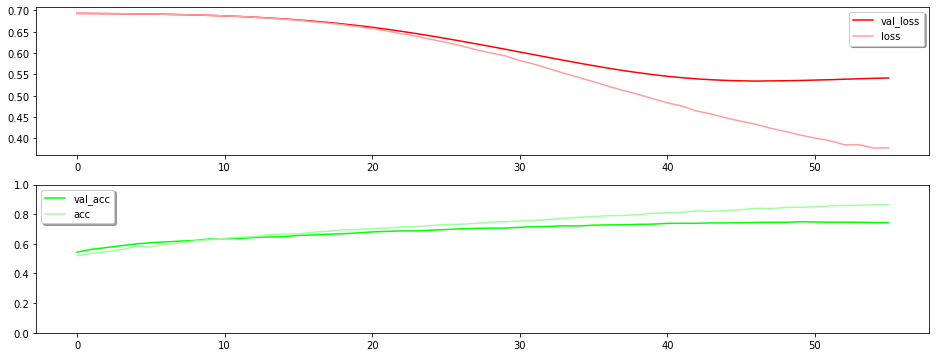

In [9]:
def bloco():
    
    import matplotlib.pyplot as plt
    
    fig, ax = plt.subplots(2,1,figsize=(16,6))
    ax[0].plot(history.history['val_loss'], color='#FF0000', label="val_loss")
    ax[0].plot(history.history['loss'], color='#FFA0A0', label="loss")
    legend = ax[0].legend(loc='best', shadow=True)
        
    ax[1].plot(history.history['val_acc'], color='#00FF00', label="val_acc")
    ax[1].plot(history.history['acc'], color='#A0FFA0', label="acc")
    ax[1].set_ylim([0.0,1.0])
    legend = ax[1].legend(loc='best', shadow=True)        
    
bloco()

In [10]:
def bloco():
    
    print( 'Seleciona o modelo com maior acurácia durante a validação (usualmente antes do overfit)' )
    
    best_acc = max(history.history['val_acc'])
    best_epoch = history.history['val_acc'].index(best_acc) + 1
    
    print( f'melhor epoca: {best_epoch} val_acc={best_acc:1.2f}' )    
        
    model.load_weights( f'model/model.{best_epoch:02d}.h5' )

bloco()

Seleciona o modelo com maior acurácia durante a validação (usualmente antes do overfit)
melhor epoca: 50 val_acc=0.75


In [11]:
X_test = tf.keras.preprocessing.sequence.pad_sequences( tokenizer.texts_to_sequences( df_test['text2'] ), maxlen=max_len )
y_test = df_test['sentiment'].values
y_pred = [ 1 if y_pred > 0.5 else 0 for y_pred in model.predict(X_test).reshape(len(X_test)) ]

df_test['predicted'] = y_pred
df_test[ ['text','sentiment','predicted'] ]

625/625 [==============================] - 54s 83ms/step


,text,sentiment,predicted
0,Hi guys! I have been dying to Tweet you.........,0,0
1,watching the MTV awards wishing i was cool eno...,1,0
2,"I'm going to shop with my BFF today, it's gonn...",0,0
3,alot of new pictures tweets ; some really old...,0,0
4,"Scariest words ever, &quot;Mommy, I cant breat...",1,1
...,...,...,...
19995,ahhh Time to relax babies are in bed.,0,0
19996,@NarelleKylie I missed you boohoo!,1,1
19997,I still cann't vote on Mr twitter. The &quot;+...,1,1
19998,it is so hot that i am totally melting now,1,1


In [12]:
def block():
    
    global confusion_mtx
    global confusion_mtx_pc
    
    confusion_mtx = tf.math.confusion_matrix( y_test, y_pred )

    confusion_mtx = pd.DataFrame( confusion_mtx )
    confusion_mtx.loc['Total'] = confusion_mtx.sum(numeric_only=True) 
    confusion_mtx['total'] = confusion_mtx[0] + confusion_mtx[1]
    
    confusion_mtx_pc = confusion_mtx / len(y_test)
    
    fp = confusion_mtx.iloc[0,1] 
    fn = confusion_mtx.iloc[1,0]
    tn = confusion_mtx.iloc[0,0]
    tp = confusion_mtx.iloc[1,1] 
    
    total = (tp+tn+fp+fn)
    
    acc       = (tp+tn)/(tp+tn+fp+fn)
    recall    = tp/(tp+fn)
    f1        = (2*acc*recall)/(acc+recall)
    
    fdr  = fp/(fp+tp)
    fnr  = fn/(fn+tp)
    
    tpr = tp/(fn+tp)
    ppv  = tp/(fp+tp)
    
    
    from IPython.display import display, HTML
    display(HTML(f"""
    
        <style>
           .luc_confusion_mtx td {{ background: white!IMPORTANT; border: 0pt !IMPORTANT; text-align: center!IMPORTANT }}           
           td.luc_confusion_mtx_dp {{ width: 90pt; height: 90pt; background: #c0ffc0!IMPORTANT; border: 1pt solid black!IMPORTANT }} 
           td.luc_confusion_mtx_dn {{ width: 90pt; height: 90pt; background: #ffc0c0!IMPORTANT; border: 1pt solid black!IMPORTANT }}            
        </style>
        
               
        <table class='luc_confusion_mtx'>
        <tr>
            <td></td>
            <td></td>
            <td colspan=2>Previsão</td>
            <td></td>
            <td rowspan=5 style='text-align: left!IMPORTANT'>
                    Acurácia<br><big><big>(TP+TN)/(total)</big></big> = {tp+tn}/{total} = <big>{(tp+tn)*100.0/total:2.1f}%</big><br>
                    <br><br>
                    Considerando que as duas classes (0=sentimento negativo;1=sentimento positivo) tem igual 
                    valor para esta análise, é importante maximizar a diagonal verde / minimizar a diagonal vermelha,
                    portanto os indicadores de Acurácia OU F1 são os mais indicados.<br>
                    <br>
                    Os indicadores de precisão e sensibilidade(recall) podem ser usados em conjunto, mas não são
                    muito intuitivos para este conjunto de dados pois mensuram da perspectiva do "sentimento positivo".
                    Em outras palavras, a sensibilidade indica quantos "sentimentos positivos" corretos foram encontrados
                    e a "precisão" indica do total apontado pelo modelo como "sentimento positivo", quantos eram. 
            </td>
        </tr>
        <tr>
            <td></td>
            <td></td>
            <td>Negativo</td>
            <td>Positivo</td>
            <td></td>            
        </tr>
        <tr>
            <td rowspan=2>Real</td>
            <td>Negativo</td>
            <td class="luc_confusion_mtx_dp"><big><big>TN</big></big><br>{tn}<br>{tn*100.0/total:2.1f}%</td>
            <td class="luc_confusion_mtx_dn"><big><big>FP</big></big><br>{fp}<br>{fp*100.0/total:2.1f}%</td>
            <td>{tn+fp}</td>
        </tr>        
        <tr>
            <td>Positivo</td>
            <td class="luc_confusion_mtx_dn"><big><big>FN</big></big><br>{fn}<br>{fn*100.0/total:2.1f}%</td>
            <td class="luc_confusion_mtx_dp"><big><big>TP</big></big><br>{tp}<br>{tp*100.0/total:2.1f}%</td>
            <td>{fn+fp}</td>
        </tr>  
        <tr>
            <td></td>
            <td></td>
            <td>{tn+fn}</td>
            <td>{fp+tp}</td>
            <td>{total}</td>
        </tr>  
        </table>    
        
        
       
    """))        
    
    print( f'             Acurácia={acc*100.0:05.2f}% dos apontamentos positivos e negativos estão corretos' )
    print( f' Recall/Sensibilidade={tpr*100.0:05.2f}% dos sentimentos positivos da base foram apontados' )   
    print( f'             Precisão={ppv*100.0:05.2f}% dos sentimentos positivos apontados estão corretos' )    
    print( f'             F1 Score={f1*100.0:05.2f}% média harmônica da acurácia e recall' )        
      

    
block()





             Acurácia=74.37% dos apontamentos positivos e negativos estão corretos
 Recall/Sensibilidade=75.41% dos sentimentos positivos da base foram apontados
             Precisão=74.27% dos sentimentos positivos apontados estão corretos
             F1 Score=74.89% média harmônica da acurácia e recall
